In [1]:
# Build an emulator based on data from all basins
# Investigate different emulator set up and methods
# spatial CV

In [2]:

import sys, os, glob, pickle, toml, json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from multiprocessing import Pool, cpu_count
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

sys.path.append("../../MOASMO_support")
from MOASMO_parameters import *

sys.path.append("/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src")
import NSGA2


def get_modified_KGE(obs,sim):
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan

    return kge, r, bias, relvar

def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

In [3]:
ncpus = 10 # used for model train (RF can use all cpus; BP-NN can only use 5 for 5-fold cross validation)

# Load data for all basins
From step-1 script

In [4]:
file = 'camels_627basin_allinfo.pkl'

if os.path.exists(file):
    # Load dataframes from the outfile
    with pd.HDFStore(file, 'r') as store:
        df_basin_info = store['df_basin_info']
        df_param_info = store['df_param_info']
        df_att = store['df_att']
else:
    print('File does not exist')

# print('df_basin_info')
# display(df_basin_info.iloc[[0]])

# print('df_param_info')
# display(df_param_info.iloc[[0]])

# print('df_att')
# display(df_att.iloc[[0]])

In [5]:
# model outputs
inpath_moasmo = "/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange"

file_defa_param = 'camels_627basin_ctsm_defa_param.csv'
if os.path.isfile(file_defa_param):
    df_param_defa = pd.read_csv(file_defa_param)
else:
    print('file_defa_param does not exist')

file_all_param = 'camels_627basin_ctsm_all_param.csv.gz'
if os.path.isfile(file_all_param):
    df_param = pd.read_csv(file_all_param, compression='gzip')
else:
    print('file_all_param does not exist')

file_all_metric = 'camels_627basin_ctsm_all_metric.csv.gz'
file_all_basinid = 'camels_627basin_ctsm_all_basinid.csv.gz'

if os.path.isfile(file_all_param):
    df_metric = pd.read_csv(file_all_metric, compression='gzip')
    df_basinid = pd.read_csv(file_all_basinid, compression='gzip')
else:
    print('file_all_param does not exist')

# remove nan values (some failed models)
index = np.isnan(np.sum(df_metric.values, axis=1))
df_param = df_param[~index]
df_metric = df_metric[~index]
df_basinid = df_basinid[~index]

df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

print('Number of nan samples:', np.sum(index))
print("Number of original parameter sets:", len(index))
print("Number of final parameter sets:", len(df_param))

Number of nan samples: 3309
Number of original parameter sets: 250800
Number of final parameter sets: 247491


In [6]:
# Load attributes for training
attlist = toml.load('camels_attributes_fortrain.toml')
att_Xie2021 = attlist['att_Xie2021']

useattrs = list(att_Xie2021.keys())
print("The number of attributes used:", len(useattrs))
print(useattrs)

The number of attributes used: 27
['p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'mean_elev', 'mean_slope', 'area_gauges2', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover_frac', 'dom_land_cover', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']


In [7]:
# load parameter upper/lower bounds for all basins

file_param_lb = 'camels_627basin_ctsm_all_param_lb.csv.gz'
file_param_ub = 'camels_627basin_ctsm_all_param_ub.csv.gz'

if os.path.isfile(file_param_lb):
    df_param_lb = pd.read_csv(file_param_lb, compression='gzip')
    df_param_ub = pd.read_csv(file_param_ub, compression='gzip')

else:
    
    param_lb_values = df_param_defa.values.copy()
    param_ub_values = df_param_defa.values.copy()
    
    for i in range(len(df_basin_info)):
        file = f"{inpath_moasmo}/level1_{i}_MOASMOcalib/param_sets/all_default_parameters.pkl"
        dfi = pd.read_pickle(file)
    
        for j in range(len(dfi['Parameter'].values)):
            indj = np.where(df_param_defa.columns.values==dfi['Parameter'].values[j])[0][0]
            param_lb_values[i, indj] = dfi['Lower'].values[j]
            param_ub_values[i, indj] = dfi['Upper'].values[j]
    
    df_param_lb = pd.DataFrame(param_lb_values, columns=df_param_defa.columns.values)
    df_param_ub = pd.DataFrame(param_ub_values, columns=df_param_defa.columns.values)
    
    df_param_lb.to_csv(file_param_lb, index=False, compression='gzip')
    df_param_ub.to_csv(file_param_ub, index=False, compression='gzip')

# create model inputs and outputs 
parameters + attributes -> obj funcs

In [8]:
# Prepare model input and output

df_input = df_param.copy()
df_input["hru_id"] = df_basinid["hru_id"]
df_input = df_input.merge(df_att[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param.columns) + useattrs
# print("Input parameters:", list(df_param.columns))
# print("Input attribuets:",  useattrs)

# if there is string attributes in the input, convert them to one-hot encoding
for att in useattrs:
    if df_input[att].dtype == "object":
        print('convert', att, 'to one-hot encoding')
        enc = OneHotEncoder(sparse=False)
        enc.fit(df_input[[att]])
        encnames = [att + "_" + str(i) for i in range(len(enc.categories_[0]))]
        print('new columns:', encnames)
        df_enc = pd.DataFrame(enc.transform(df_input[[att]]), columns=encnames)
        df_input = pd.concat([df_input, df_enc], axis=1)
        df_input = df_input.drop([att], axis=1)
        inputnames = [i for i in inputnames if i != att] + encnames


# convert to numpy array for training / testing
# print("Input parameters after adjustment:", list(df_param.columns))
# print("Input attribuets after adjustment:",  useattrs)

x_all = df_input[inputnames].values.copy()
print("Input shape:", x_all.shape)

convert dom_land_cover to one-hot encoding
new columns: ['dom_land_cover_0', 'dom_land_cover_1', 'dom_land_cover_2', 'dom_land_cover_3', 'dom_land_cover_4', 'dom_land_cover_5', 'dom_land_cover_6', 'dom_land_cover_7', 'dom_land_cover_8', 'dom_land_cover_9', 'dom_land_cover_10', 'dom_land_cover_11']
Input shape: (247491, 65)


In [9]:
# check what metrics to be used as optimzation targets

# fig = plt.figure(figsize=[10, 4])

# flag = 1
# for i in ['kge', 'mae', 'n_mae', 'nse', 'cc', 'rmse', 'max_mon_abs_err', 'n_max_mon_abs_err',  'kge_log_q']:
#     fig.add_subplot(3, 3, flag)
#     flag = flag + 1
#     plt.plot(df_metric[i].values)
#     plt.title(i)
    
# plt.tight_layout()
# plt.show()

# plt.hist(df_output[["rmse"]].values)
# plt.hist(df_output[["kge"]].values, np.arange(-10, 1, 0.01))

## Outputs

In [10]:
# use normalized kge as output

df_output = df_metric.copy()
y_all = df_output[["kge"]].values.copy()
y_all = y_all / (2 - y_all) # normalize KGE

print("Output shape:", y_all.shape)

Output shape: (247491, 1)


# Train / Test emulators

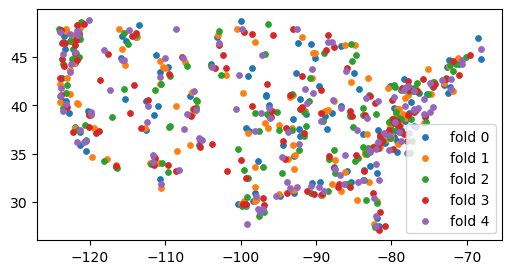

In [11]:
def get_cv_indices(df_basinid, nfold=5):
    from sklearn.model_selection import GroupKFold

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=nfold)

    # Dictionary to store train and test indices
    cv_indices = {}

    # Cross-validation process to save indices
    # does not depend on random seeds
    for fold, (train_index, test_index) in enumerate(group_kfold.split(df_basinid, groups=df_basinid['basin_num'])):
        
        train_basin = np.unique(df_basinid.iloc[train_index]['basin_id'].values)
        test_basin = np.unique(df_basinid.iloc[test_index]['basin_id'].values)

        cv_indices[fold] = {'train_index': train_index, 'test_index': test_index, 'train_basin': train_basin, 'test_basin': test_basin} 
    return cv_indices

# Get the indices
nfold = 5
cv_indices = get_cv_indices(df_basinid, nfold)

# plot test basin batches
fig = plt.figure(figsize=(6, 3))
for fold in range(len(cv_indices)):
    test_basin = cv_indices[fold]['test_basin']
    lat = df_basin_info.iloc[test_basin]['lat_cen'].values
    lon = df_basin_info.iloc[test_basin]['lon_cen'].values
    plt.scatter(lon, lat, 15, label=f'fold {fold}')

plt.legend()
plt.show()

# Train one final emulator model

0.029377721377637375


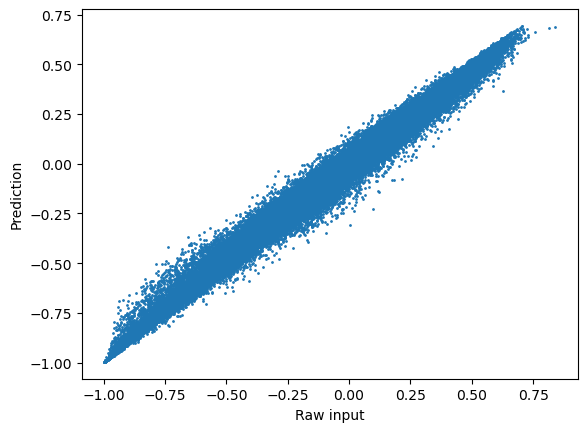

In [12]:
# train an RF model using all samples

outfile = '/glade/work/guoqiang/CTSM_CAMELS/analyses/emulator_comp/allbasin_emulator_allsample_rf.pkl'
if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        rf_model = pickle.load(file)
else:
    # Initialize a new MLPRegressor for each fold
    modelconfig = {'n_estimators': 100, 'random_state': 42, 'max_depth': 40}
    # Initialize a new RandomForestRegressor for each fold
    rf_model = RandomForestRegressor(**modelconfig, n_jobs=ncpus)
            
    # Train the model
    rf_model.fit(x_all, y_all)
    
    with open(outfile, 'wb') as file:
        pickle.dump(rf_model, file)
        
# Predict on the test set
y_pred = rf_model.predict(x_all)

# evaluation
rmse_rf = get_rmse(y_all[:, 0], y_pred)
print(rmse_rf)

plt.scatter(y_all[:,0], y_pred, 1)
plt.xlabel('Raw input')
plt.ylabel('Prediction')
plt.show()

0.08532857250975963


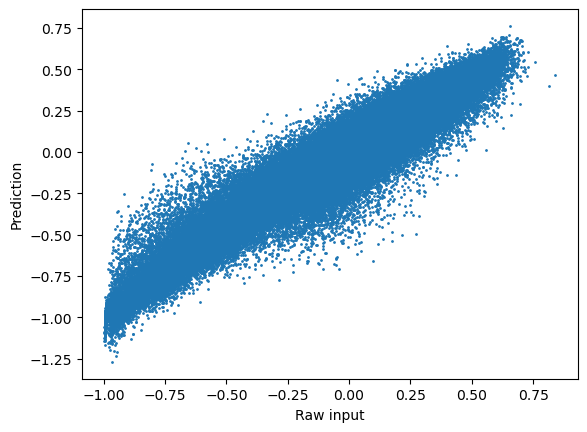

In [13]:
# train an ANN model using all samples

x_all_mean = np.nanmean(x_all, axis=0)
x_all_std = np.nanstd(x_all, axis=0)
x_all_norm = (x_all - x_all_mean) / x_all_std

y_all_mean = np.nanmean(y_all, axis=0)
y_all_std = np.nanstd(y_all, axis=0)
y_all_norm = (y_all - y_all_mean) / y_all_std


outfile = '/glade/work/guoqiang/CTSM_CAMELS/analyses/emulator_comp/allbasin_emulator_allsample_ann_meanstdnorm.pkl'
if os.path.isfile(outfile):
# if False:
    with open(outfile, 'rb') as file:
        bp_model = pickle.load(file)
else:
    # Initialize a new MLPRegressor for each fold
    modelconfig = {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
    bp_model = MLPRegressor(**modelconfig)
        
    # Train the model
    bp_model.fit(x_all_norm, y_all_norm)
    
    with open(outfile, 'wb') as file:
        pickle.dump(bp_model, file)
        
# Predict on the test set
y_pred_norm = bp_model.predict(x_all_norm)
y_pred = y_pred_norm*y_all_std+y_all_mean


# evaluation
rmse_bp = get_rmse(y_all[:, 0], y_pred)
print(rmse_bp)

plt.scatter(y_all[:,0], y_pred, 1)
plt.xlabel('Raw input')
plt.ylabel('Prediction')
plt.show()
        

# Get optimized parameters from the emulator

In [24]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.termination import get_termination


# Assuming em_model is your trained model
# xlb_mean and xub_mean are your lower and upper bounds respectively

class MyProblem(Problem):
    def __init__(self):
        super().__init__(n_var=len(xlb_mean), n_obj=1, n_constr=0, xl=xlb_mean, xu=xub_mean, elementwise_evaluation=False)

    def _evaluate(self, x, out, *args, **kwargs):
        # Predict expects a 2D array, so we pass x directly
        out["F"] = -em_model.predict(x)  # Return negative to maximize

def run_ga_optimization(em_model, xlb_mean, xub_mean, num_runs=100, pop_size=100, num_generations=100):
    ga_all_solutions = []
    ga_all_outputs = []

    for i in range(num_runs):  # run the model `num_runs` times
        problem = MyProblem()
        
        algorithm = GA(
            pop_size=100,
            sampling=FloatRandomSampling(),
            crossover=SimulatedBinaryCrossover(prob=0.9, eta=15),
            mutation=PolynomialMutation(eta=20),
            eliminate_duplicates=True
        )
        
        res = minimize(problem,
                       algorithm,
                       termination=get_termination("n_gen", 100),
                       verbose=False)
        
        optimized_features = res.X
        max_output = -res.F
        
        ga_all_solutions.append(optimized_features)
        ga_all_outputs.append(np.squeeze(max_output))
    
    return np.array(ga_all_solutions), np.array(ga_all_outputs)


def generate_param_files(tarbasin, em_model, xlb_mean, xub_mean, param_names, inpath_moasmo):
    
    path_CTSM_case = f'/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_MOASMO_bigrange/level1_{tarbasin}'
    outpath = f'{inpath_moasmo}/level1_{tarbasin}_MOASMOcalib/param_sets_emutest'
    os.makedirs(outpath, exist_ok=True)

    if True:
        # Run GA optimization
        outfile_ga = f'{outpath}/ga_output_iter1.npz'
        if os.path.isfile(outfile_ga):
            dtmp = np.load(outfile_ga)
            ga_all_solutions = dtmp['ga_all_solutions']
            ga_all_outputs = dtmp['ga_all_outputs']
        else:
            ga_all_solutions, ga_all_outputs = run_ga_optimization(em_model, xlb_mean, xub_mean, num_runs=100, pop_size=100, num_generations=100)
            np.savez_compressed(outfile_ga, ga_all_solutions=ga_all_solutions, ga_all_outputs=ga_all_outputs)
        
        # Generate parameter dataframe for next trial
        df_info = pd.read_pickle(f'{inpath_moasmo}/level1_{tarbasin}_MOASMOcalib/param_sets/paramset_iter0_trial0.pkl')
        df_info = df_info.loc[df_info['Default'] != 'None']
        
        df_info['Factor'] = np.nan
        df_info['Value'] = np.nan


        
        ga_all_solutions_array = np.array(ga_all_solutions)

        # print(df_info)
        # print(param_names)
        
        indexp = [np.where(param_names == p)[0][0] for p in df_info['Parameter'].values if p in param_names]

        for i in range(ga_all_solutions_array.shape[0]):
            outfile = f'{outpath}/paramset_iter1_trial{i}.pkl'

            if os.path.isfile(outfile):
                continue

            # print('Generating parameter file:', outfile)

            dfi = df_info.copy()
            dfi['Value'] = ga_all_solutions_array[i, indexp]

            # Process binded parameters
            dfi = check_and_generate_binded_parameters(dfi, path_CTSM_case)

            # Write to file
            dfi.to_pickle(outfile)


In [25]:
em_model = rf_model

param_names = df_param_info['Parameter'].values
    
# for tarbasin in range(len(df_basin_info)):
for tarbasin in range(311, 627, 10):
    print(tarbasin)
    
    index = np.where(df_basinid["basin_num"].values == tarbasin)[0]
    hruid = df_basinid["hru_id"].values[index[0]]
        
    attnames = [i for i in inputnames if not i in param_names]
    # attrvalues = df_input.iloc[index[0]][attnames].values
        
    param_lb_mean = df_param_lb.values[tarbasin, :]
    param_ub_mean = df_param_ub.values[tarbasin, :]

    attrvalues = x_all[index[0], len(param_lb_mean):] # same with df_input
    if np.any( attrvalues != df_input.iloc[index[0]][attnames].values):
        print('Warning! att problem')
    
    x_tar = x_all[index, :]
    y_tar = y_all[index, :]
    xlb_mean = np.hstack([param_lb_mean, attrvalues])
    xub_mean = np.hstack([param_ub_mean, attrvalues])

    # run_ga_optimization
    # ga_all_solutions, ga_all_outputs = run_ga_optimization(em_model, xlb_mean, xub_mean, num_runs=100)
    generate_param_files(tarbasin, em_model, xlb_mean, xub_mean, param_names, inpath_moasmo)

311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
